## POS tagging using modified Viterbi

### Data Preparation

In [49]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [50]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [51]:
# Splitting into train and validation set()[95:5]
train_set, validation_set = train_test_split(nltk_data,test_size=0.05)

print("Train set :",len(train_set))
print("Validation set : ",len(validation_set))

Train set : 3718
Validation set :  196


In [52]:
# Getting list of tagged words
train_tagged_words =[tup for sent in train_set for tup in sent]
print("List of tagged words in train_set : ",len(train_tagged_words))

# Separating the tokens or words from the train_tagged_words
tokens = [pair[0] for pair in train_tagged_words]
print("Few Tokens : ",tokens[:10])


# Taking the unique words, this is called the vocabulary of the train dataset.
V = set(tokens)
print("Vocabulary count : ",len(V))


# number of unique tags extracting from train_tagged_words
T = set([pair[1] for pair in train_tagged_words])
print("No. of unique tags : {}".format(len(T)))
print("12 tags : ",list(T))

List of tagged words in train_set :  95695
Few Tokens :  ['A', 'steady', 'deposit', 'base', '.', 'BRAMALEA', 'Ltd.', 'said', '0', 'it']
Vocabulary count :  12137
No. of unique tags : 12
12 tags :  ['.', 'NOUN', 'PRT', 'X', 'DET', 'NUM', 'ADP', 'CONJ', 'PRON', 'ADV', 'ADJ', 'VERB']


### Build the vanilla Viterbi based POS tagger

To build the vanilla Viterbi based POS tagger we need emission and tranisition probability. So let's define functions to calculate them.

#### Emission Probabilities

In [53]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [54]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition probabilities

In [55]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [56]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,.,NOUN,PRT,X,DET,NUM,ADP,CONJ,PRON,ADV,ADJ,VERB
.,0.093823,0.222292,0.002328,0.026768,0.173142,0.081468,0.091316,0.057833,0.065264,0.053089,0.043688,0.088899
NOUN,0.240158,0.264203,0.043456,0.028788,0.013464,0.009596,0.176269,0.042580,0.004889,0.016930,0.012223,0.147444
PRT,0.043092,0.248355,0.001974,0.012829,0.100329,0.055263,0.021053,0.002303,0.018092,0.009868,0.083882,0.402961
X,0.166243,0.061924,0.184185,0.075103,0.054779,0.001905,0.144332,0.010638,0.054621,0.025087,0.017625,0.203557
DET,0.017855,0.636386,0.000241,0.045965,0.005670,0.022439,0.009410,0.000483,0.003378,0.013150,0.205212,0.039812
NUM,0.115624,0.350133,0.027275,0.214053,0.002965,0.183516,0.036170,0.014231,0.001186,0.002965,0.033798,0.018085
ADP,0.040350,0.322054,0.001494,0.035226,0.323121,0.062553,0.016973,0.000854,0.069065,0.013557,0.106426,0.008326
CONJ,0.035201,0.353404,0.004169,0.008800,0.117647,0.041686,0.053265,0.000463,0.058360,0.054192,0.114868,0.157943
PRON,0.041170,0.210466,0.011928,0.091958,0.009619,0.007311,0.023471,0.005387,0.008080,0.035398,0.071566,0.483648
ADV,0.136664,0.031767,0.013898,0.022833,0.069821,0.031767,0.118465,0.007280,0.015553,0.078425,0.130708,0.342819


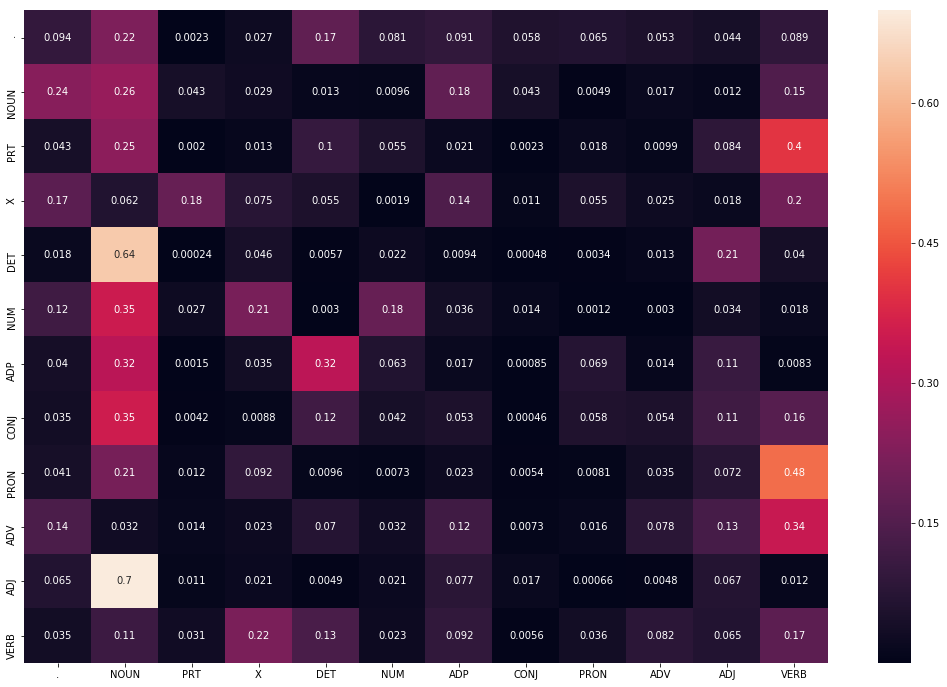

In [57]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()

#### Viterbi Algorithm

In [58]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on validation set

In [59]:
# list of tagged words
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_set for tup in sent]

print("List of few  tagged words in validation set : ",validation_run_base[:10])
print("Few words in validation set : ",validation_tagged_words[:10])

List of few  tagged words in validation set :  [('Commonwealth', 'NOUN'), ('Edison', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('ruling', 'NOUN'), ('could', 'VERB'), ('force', 'VERB'), ('it', 'PRON'), ('to', 'PRT')]
Few words in validation set :  ['Commonwealth', 'Edison', 'said', '0', 'the', 'ruling', 'could', 'force', 'it', 'to']


In [60]:
# tagging the test sentences to viterbi
start = time.time()
tagged_seq = Viterbi(validation_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


# accuracy
check = [i for i, j in zip(tagged_seq, validation_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, validation_run_base)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases)/len(tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases))

Time taken in seconds:  946.5091254711151
Accuracy : 0.9168841598072676
% of incorrect tagged cases : 0.08311584019273238
Count of incorrect tagged cases :  414


### Solve the problem of unknown words

#### Technique 1 : Using rule based POS tagging
In this technique,
- Assigning a new tag 'unknownWord' to all the new words.
- Now the words are passed to a function 'rule_based_tagging' 
- For the words with tag 'unknownWord', defined pattern rule is applied.

In [61]:
# User-defined Function to perform Rule-Based Tagging, this will be called from Viterbi Algorithm function. 

def rule_based_tagging(words, state):
    
    # specify patterns for tagging
    # example from the NLTK book
    patterns = [
        (r'.*ing$', 'VERB'),              # gerund
        (r'.*ed$', 'VERB'),               # past tense
        (r'.*es$', 'VERB'),               # 3rd singular present
        (r'.*\*.*', 'X'),                # plural nouns 
        (r'([0-9])+.*$', 'NUM'), # cardinal numbers
        (r'.*', 'NOUN')                    # nouns
    ]
    
    regexp_tagger = nltk.RegexpTagger(patterns)

    for i,j in enumerate(state):
        #Rule-based tagging done only for new 'unknownWord' words.
        if j == "unknownWord":
            state[i] = regexp_tagger.tag([words[i]])[0][1]
    return words,state


# Viterbi Heuristic function using Rule Based Approach
def ViterbiUsingRuleBased(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                #If previous tag is 'unknownWord' make transition_p = 1, so that emission_p alone decides the tag. 
                if (state[-1] == 'unknownWord'):
                    transition_p = 1
                else:             
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax==0:
            #if pmax = 0, means the the word is a new word, in such case mark the word tag as "unknownWord".
            state_max='unknownWord'
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 

        state.append(state_max)
    word, state = rule_based_tagging(words, state) #Rule-based function called for all 'unknownWord'.
    return list(zip(words, state))

In [62]:
# Tagging the validation set sentences

start = time.time()
rule_based_tagged_seq = ViterbiUsingRuleBased(validation_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  939.5471251010895


#### Evaluating tagging accuracy

In [63]:
# accuracy
check = [i for i, j in zip(rule_based_tagged_seq, validation_run_base) if i == j] 
accuracy = len(check)/len(rule_based_tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases_rule_based = [[validation_run_base[i-1],j] for i, j in enumerate(zip(rule_based_tagged_seq, validation_run_base)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases_rule_based)/len(rule_based_tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases_rule_based))

Accuracy : 0.9566352138124875
% of incorrect tagged cases : 0.04336478618751255
Count of incorrect tagged cases :  216


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

We can see that with original viterbi we achieved accuracy of 91.6 % whereas using rule based we achieved an accuracy of 95.66%

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [64]:
#Words with modified tags out of which few are correctly predicted
for x in list(set(tagged_seq)):
    for y in list(set(rule_based_tagged_seq)):
        if ((x[0]==y[0]) & (x[1]!=y[1])):
             print('Using Viterbi - {} |  {} - Using Rule based viterbi'.format(x,y))

Using Viterbi - ('codified', '.') |  ('codified', 'VERB') - Using Rule based viterbi
Using Viterbi - ('screwed', '.') |  ('screwed', 'VERB') - Using Rule based viterbi
Using Viterbi - ('dolls', '.') |  ('dolls', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('109.73', '.') |  ('109.73', 'NUM') - Using Rule based viterbi
Using Viterbi - ('Arbitrage-related', '.') |  ('Arbitrage-related', 'VERB') - Using Rule based viterbi
Using Viterbi - ('talk', 'NOUN') |  ('talk', 'VERB') - Using Rule based viterbi
Using Viterbi - ('expenditures', '.') |  ('expenditures', 'VERB') - Using Rule based viterbi
Using Viterbi - ('slew', '.') |  ('slew', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('Goldinger', '.') |  ('Goldinger', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('slash', '.') |  ('slash', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('container', '.') |  ('container', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('appealing', '.') |  ('appealing', 'VERB') - Using

Using Viterbi - ('copycats', '.') |  ('copycats', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('more', 'ADJ') |  ('more', 'ADV') - Using Rule based viterbi
Using Viterbi - ('face', 'VERB') |  ('face', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('13\\/16', '.') |  ('13\\/16', 'NUM') - Using Rule based viterbi
Using Viterbi - ('NRDC', '.') |  ('NRDC', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('trading', 'NOUN') |  ('trading', 'VERB') - Using Rule based viterbi
Using Viterbi - ('use', 'NOUN') |  ('use', 'VERB') - Using Rule based viterbi
Using Viterbi - ('7.60', '.') |  ('7.60', 'NUM') - Using Rule based viterbi
Using Viterbi - ('earlier', 'ADV') |  ('earlier', 'ADJ') - Using Rule based viterbi
Using Viterbi - ('close', 'VERB') |  ('close', 'ADJ') - Using Rule based viterbi
Using Viterbi - ('identical', '.') |  ('identical', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('bend', '.') |  ('bend', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('risk', 'VER

Using Viterbi - ('public', 'ADJ') |  ('public', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('induce', '.') |  ('induce', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('spurring', '.') |  ('spurring', 'VERB') - Using Rule based viterbi
Using Viterbi - ('Marina', '.') |  ('Marina', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('Menem', '.') |  ('Menem', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('afterwards', '.') |  ('afterwards', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('sogo-shosha', '.') |  ('sogo-shosha', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('converting', '.') |  ('converting', 'VERB') - Using Rule based viterbi
Using Viterbi - ('EURODOLLARS', '.') |  ('EURODOLLARS', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('Income', '.') |  ('Income', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('ready', '.') |  ('ready', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('conferees', '.') |  ('conferees', 'VERB') - Using Rul

We can see that words with POS tags using viterbi and rule based vetrbi in the above.
Eg: '1991-2000' is tagged to NOUN in viterbi and with help of rule based its correctly tagged to NUM,
    'milked' is tagged to NOUN in viterbi and with help of rule based its correctly tagged to VERB, etc.
Similarly for all

#### Technique 2 : Modifying Viterbi fucntion

In orginal viterbi approach, state probability is being calculated by multiplying both emission_p and transition_p.
Now in this technique,we are adding a condtion that if emission_p is 0 i.e a new word then we use transition_p  as the state probability.

In [65]:
# Viterbi Heuristic
def ViterbiModified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        transition=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            transition.append(transition_p)
            
        pmax = max(p)
        if pmax==0:#Emmission probability is 0 and hence it is a new word.
            pmax=max(transition)# Finding the maximum transition probability.
            state_max = T[transition.index(pmax)] # transition probability will decide the new tag.
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] # If emission_p !=0 then state_probability is calculated as usual.

        state.append(state_max)
    
    return list(zip(words, state))

In [66]:
# Tagging the validation set sentences using modified viterbi

start = time.time()
modified_viterbi_tagged_seq = ViterbiModified(validation_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  950.4469175338745


#### Evaluating tagging accuracy

In [67]:
# accuracy
check = [i for i, j in zip(modified_viterbi_tagged_seq, validation_run_base) if i == j] 
accuracy = len(check)/len(modified_viterbi_tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases_modified_viterbi = [[validation_run_base[i-1],j] for i, j in enumerate(zip(modified_viterbi_tagged_seq, validation_run_base)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases_modified_viterbi)/len(modified_viterbi_tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases_modified_viterbi))

Accuracy : 0.9443886769724955
% of incorrect tagged cases : 0.05561132302750452
Count of incorrect tagged cases :  277


We can see that with original viterbi we achieved accuracy of 91.6 % whereas after modifying viterbi fucntion with technique 2 we achieved an accuracy of 94.4%

In [68]:
#Words with modified tags out of which few are correctly predicted
for x in list(set(tagged_seq)):
    for y in list(set(modified_viterbi_tagged_seq)):
        if ((x[0]==y[0]) & (x[1]!=y[1])):
             print('Using Viterbi - {} |  {} - Using Modified viterbi technique'.format(x,y))

Using Viterbi - ('codified', '.') |  ('codified', 'X') - Using Modified viterbi technique
Using Viterbi - ('screwed', '.') |  ('screwed', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('dolls', '.') |  ('dolls', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('109.73', '.') |  ('109.73', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('Arbitrage-related', '.') |  ('Arbitrage-related', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('talk', 'NOUN') |  ('talk', 'VERB') - Using Modified viterbi technique
Using Viterbi - ('expenditures', '.') |  ('expenditures', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('slew', '.') |  ('slew', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('Goldinger', '.') |  ('Goldinger', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('slash', '.') |  ('slash', 'VERB') - Using Modified viterbi technique
Using Viterbi - ('container', '.') |  ('container', 'NOUN') - Using Modified

Using Viterbi - ('enough', 'ADJ') |  ('enough', 'ADV') - Using Modified viterbi technique
Using Viterbi - ('2,410', '.') |  ('2,410', 'DET') - Using Modified viterbi technique
Using Viterbi - ('publication', '.') |  ('publication', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('tell', '.') |  ('tell', 'VERB') - Using Modified viterbi technique
Using Viterbi - ('0.54', '.') |  ('0.54', 'DET') - Using Modified viterbi technique
Using Viterbi - ('Lorenzo', '.') |  ('Lorenzo', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('*-110', '.') |  ('*-110', 'X') - Using Modified viterbi technique
Using Viterbi - ('tows', '.') |  ('tows', 'VERB') - Using Modified viterbi technique
Using Viterbi - ('*T*-187', '.') |  ('*T*-187', 'X') - Using Modified viterbi technique
Using Viterbi - ('trading', 'VERB') |  ('trading', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('error', '.') |  ('error', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('Lurie', '

Using Viterbi - ('spurring', '.') |  ('spurring', 'VERB') - Using Modified viterbi technique
Using Viterbi - ('Marina', '.') |  ('Marina', 'DET') - Using Modified viterbi technique
Using Viterbi - ('Menem', '.') |  ('Menem', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('afterwards', '.') |  ('afterwards', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('sogo-shosha', '.') |  ('sogo-shosha', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('converting', '.') |  ('converting', 'X') - Using Modified viterbi technique
Using Viterbi - ('EURODOLLARS', '.') |  ('EURODOLLARS', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('Income', '.') |  ('Income', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('ready', '.') |  ('ready', 'X') - Using Modified viterbi technique
Using Viterbi - ('conferees', '.') |  ('conferees', 'NOUN') - Using Modified viterbi technique
Using Viterbi - ('anti-China', '.') |  ('anti-China', 'DET') - Using Modifi

We can see that words with POS tags using viterbi and modified vetrbi in the above.
Eg: 'rise' is tagged to NOUN in viterbi and with help of modified viterbi its correctly tagged to VERB,
    'tackle' is tagged to NOUN in viterbi and with help of modified viterbi its correctly tagged to VERB, etc.
Similarly for all

### Applying Technique 1 and Technique 2 on test_set i.e., Test_Sentences.txt file

In [69]:
test=open('Test_sentences.txt', 'r')
test_set = test.read()
test_set

"Android is a mobile operating system developed by Google.\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\nShow me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\nNASA invited social media users to experience the launch of ICESAT-2 Satell

In [70]:
words = word_tokenize(test_set)

universal_tags = nltk.pos_tag(words, tagset='universal')

# list of test words
test_words = [tup[0] for tup in universal_tags]

#### Viterbi Algorithm

In [71]:
# tagging the test sentences to viterbi
start = time.time()
test_tagged_seq = Viterbi(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


# accuracy
check = [i for i, j in zip(test_tagged_seq, universal_tags) if i == j] 
accuracy = len(check)/len(test_tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases_test = [[universal_tags[i-1],j] for i, j in enumerate(zip(test_tagged_seq, universal_tags)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases_test)/len(test_tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases_test))

Time taken in seconds:  34.92054843902588
Accuracy : 0.7624309392265194
% of incorrect tagged cases : 0.23756906077348067
Count of incorrect tagged cases :  43


#### Technique 1 : Using rule based POS tagging

In [72]:
# Tagging the validation set sentences

start = time.time()
rule_based_test_tagged_seq = ViterbiUsingRuleBased(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


# accuracy
check = [i for i, j in zip(rule_based_test_tagged_seq, universal_tags) if i == j] 
accuracy = len(check)/len(rule_based_test_tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases_test_rule = [[universal_tags[i-1],j] for i, j in enumerate(zip(rule_based_test_tagged_seq, universal_tags)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases_test_rule)/len(rule_based_test_tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases_test_rule))

Time taken in seconds:  35.41353702545166
Accuracy : 0.9337016574585635
% of incorrect tagged cases : 0.06629834254143646
Count of incorrect tagged cases :  12


We can see that with original viterbi we achieved accuracy of 76.24 % whereas using rule based we achieved an accuracy of 93.3%

In [73]:
#Words with modified tags out of which few are correctly predicted
for x in list(set(test_tagged_seq)):     
    for y in list(set(rule_based_test_tagged_seq)):
        if ((x[0]==y[0]) & (x[1]!=y[1])):
             print('Using Viterbi - {} |  {} - Using Rule based viterbi'.format(x,y))

Using Viterbi - ('invited', '.') |  ('invited', 'VERB') - Using Rule based viterbi
Using Viterbi - ('NASA', '.') |  ('NASA', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('messages', '.') |  ('messages', 'VERB') - Using Rule based viterbi
Using Viterbi - ('2018', '.') |  ('2018', 'NUM') - Using Rule based viterbi
Using Viterbi - ('2013', '.') |  ('2013', 'NUM') - Using Rule based viterbi
Using Viterbi - ('contested', '.') |  ('contested', 'VERB') - Using Rule based viterbi
Using Viterbi - ('arriving', '.') |  ('arriving', 'VERB') - Using Rule based viterbi
Using Viterbi - ('Cup', '.') |  ('Cup', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('21st', '.') |  ('21st', 'NUM') - Using Rule based viterbi
Using Viterbi - ('worldwide', '.') |  ('worldwide', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('Android', '.') |  ('Android', 'NOUN') - Using Rule based viterbi
Using Viterbi - ('domineering', '.') |  ('domineering', 'VERB') - Using Rule based viterbi
Using Viterbi - ("'

#### Technique 2 : Modifying Viterbi fucntion

In [74]:
# Tagging the validation set sentences

start = time.time()
modified_viterbi_test_tagged_seq = ViterbiModified(test_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)


# accuracy
check = [i for i, j in zip(modified_viterbi_test_tagged_seq, universal_tags) if i == j] 
accuracy = len(check)/len(modified_viterbi_test_tagged_seq)
print("Accuracy : {}".format(accuracy))

#Incorrect Tagged cases
incorrect_tagged_cases_test_modified = [[universal_tags[i-1],j] for i, j in enumerate(zip(modified_viterbi_test_tagged_seq, universal_tags)) if j[0]!=j[1]]
print("% of incorrect tagged cases : {}".format(len(incorrect_tagged_cases_test_modified)/len(modified_viterbi_test_tagged_seq)))
print("Count of incorrect tagged cases : ",len(incorrect_tagged_cases_test_modified))

Time taken in seconds:  34.65795302391052
Accuracy : 0.8674033149171271
% of incorrect tagged cases : 0.13259668508287292
Count of incorrect tagged cases :  24


In [75]:
#Words with modified tags out of which few are correctly predicted
for x in list(set(test_tagged_seq)):
    for y in list(set(modified_viterbi_test_tagged_seq)):
        if ((x[0]==y[0]) & (x[1]!=y[1])):
             print('Using Viterbi - {} |  {} - Using Modified viterbi'.format(x,y))

Using Viterbi - ('invited', '.') |  ('invited', 'NOUN') - Using Modified viterbi
Using Viterbi - ('NASA', '.') |  ('NASA', 'NOUN') - Using Modified viterbi
Using Viterbi - ('messages', '.') |  ('messages', 'DET') - Using Modified viterbi
Using Viterbi - ('2018', '.') |  ('2018', 'NOUN') - Using Modified viterbi
Using Viterbi - ('2013', '.') |  ('2013', 'DET') - Using Modified viterbi
Using Viterbi - ('contested', '.') |  ('contested', 'NOUN') - Using Modified viterbi
Using Viterbi - ('arriving', '.') |  ('arriving', 'NOUN') - Using Modified viterbi
Using Viterbi - ('Cup', '.') |  ('Cup', 'NOUN') - Using Modified viterbi
Using Viterbi - ('21st', '.') |  ('21st', 'NOUN') - Using Modified viterbi
Using Viterbi - ('worldwide', '.') |  ('worldwide', 'NOUN') - Using Modified viterbi
Using Viterbi - ('Android', '.') |  ('Android', 'NOUN') - Using Modified viterbi
Using Viterbi - ('domineering', '.') |  ('domineering', 'NOUN') - Using Modified viterbi
Using Viterbi - ("'s", 'VERB') |  ("'s", '

We can see that with original viterbi we achieved accuracy of 76.24 % whereas using modified viterbi  we achieved an accuracy of 86.7%.